In [1]:
%matplotlib inline

import os 
import sys 
import time
import hashlib

from datetime  import datetime 

import numpy as np  # learn 
import pandas as pd # learn
from pandas import *
from numpy import *

from scipy import stats # look at scipy
from scipy import linalg
from scipy import *
 
import matplotlib as mplt # learn matplolib 
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# import seaborn as sns 
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (14, 6)})

import IPython
from IPython.display import display


import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
 
# import sklearn as sk
import itertools

# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *
# from pyspark.mllib.regression import LabeledPoint

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import *
# RMSprop, Adadelta
from keras.regularizers import l2, activity_l2

import scipy.stats as st

# http://sebastianruder.com/optimizing-gradient-descent/
# https://leemendelowitz.github.io/blog/how-does-python-find-packages.html

Using Theano backend.


(1441, 3)
size of clean data: (1434, 3)
size of noisy data: (1441,) 1441
      timestamp  value  is_anomaly
359         360  52179           1
778         779  37998           1
779         780   8792           1
1066       1067   1059           1
1069       1070  89188           1
1070       1071  89397           1
1247       1248  63961           1


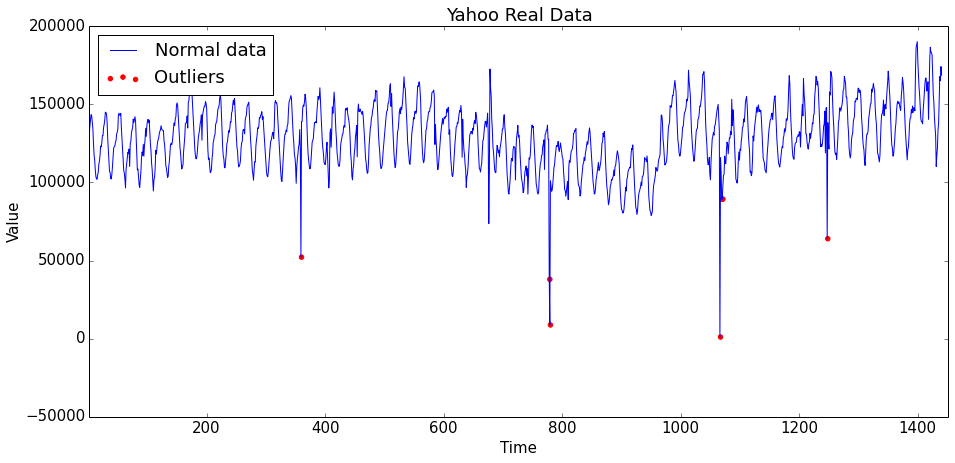

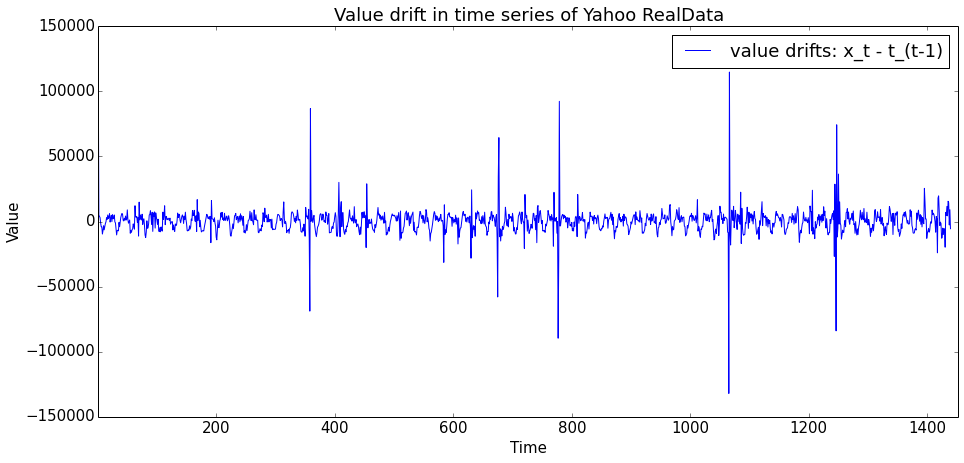

In [9]:
# block1: Training dataset

# load and extract yahoo data
# choose the data in files real_11-20, which contains a time series (data point 3000 - 10000) with mediate 
#  outlier magnitude 

#  this dataset will be used for realtime training RNN 
# 6,13,15,11,22,29,56,31,39,57,43,65, 55,62


# 13 23 29 44
# final chosen one: 2,3

is_clean=0


curr_cnt=0
st_file=29
ed_file=30

dta_folder="/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_"
# dta_folder=
# "/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_"

for i in range(st_file, ed_file):
    tmpdf= pd.read_csv( dta_folder + str(i) + ".csv")
    
#     tmpdf[ 'timestamp' ] = tmpdf[ 'timestamp' ].astype(int64)
#     tmpdf[ 'value' ] = tmpdf[ 'value' ].astype(float64)
#     tmpdf[ 'is_anomaly' ] = tmpdf[ 'is_anomaly' ].astype(int64)
    
    print tmpdf.shape
    
    if (i-st_file) == 0 :
        tdf1= tmpdf
    else:
        tmpdf.drop('timestamp', axis=1, inplace=True)
        tmp_col=  range( curr_cnt+1, curr_cnt + tmpdf.shape[0]+1 ) 
        tmpdf.insert(0, 'timestamp', tmp_col)
        tdf1 = tdf1.append(tmpdf)
    
    curr_cnt = curr_cnt + tmpdf.shape[0]


tdf=tdf1
    
maxval= max(tdf['value'])
minval= min(tdf['value'])

outlier_tdf= tdf[ tdf['is_anomaly'] ==1  ]
clean_tdf =  tdf[ tdf['is_anomaly'] ==0  ]

if is_clean==1:
    ts= clean_tdf['value']
else:
    ts= tdf['value']
    
ts_flag= list(tdf['is_anomaly'])

print "size of clean data:",clean_tdf.shape
print "size of noisy data:", ts.shape, len(ts_flag)

print outlier_tdf
# .............plot.................

matplotlib.rcParams.update({'font.size': 15})
figure_size= ( 15.4,7)
legend_font= 8.5
fig = plt.figure()
fig.set_size_inches( figure_size )

axes = plt.gca()
axes.set_xlim([1, tdf.shape[0]+10])
# axes.set_ylim([-2000,maxval+2000])

plt.plot( list( tdf['value']), label='Normal data' )
# plt.plot( list( clean_tdf['value']), color='g' )
plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
             label='Outliers')
# plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
# axes.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Yahoo Real Data')
plt.ylabel('Value')
plt.xlabel('Time')
# plt.legend( loc='upper left',fontsize=12 )
plt.legend(loc='upper left')
#     bbox_to_anchor=(0., 1.0, 1., .10),
#            loc=0,
#            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')


def value_drift_observe( ts ):
    valDrift =  [ ts[i+1]-ts[i] for i in range(len(ts)-1) ]
    
    fig = plt.figure()
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )

    axes = plt.gca()
    axes.set_xlim([1, len(ts)+10])
#     axes.set_ylim([-2000,maxval+2000])

    plt.plot( valDrift, label='value drifts: x_t - t_(t-1)' )
# plt.plot( list( clean_tdf['value']), color='g' )
# plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')
# plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
# axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Value drift in time series of Yahoo RealData')
    plt.ylabel('Value')
    plt.xlabel('Time')
# plt.legend( loc='upper left',fontsize=12 )
    plt.legend()
    
#     fig.savefig('time_size.pdf', format='pdf', bbox_inches='tight')
    
    
value_drift_observe( list(tdf['value']) )  


In [3]:
# block2: data pre-processing

# re-organize the data to the format for feeding into the RNN 

import pandas as pd
from random import random
import numpy as np


def extract_load_data( ts_df, st_idx, ed_idx):
    tmpdta = ts_df.iloc[st_idx: ed_idx]
    cnt= len(tmpdta)
    tmpx=[]
    tmpy=[]
    for i in range(cnt-1):
        tmpx.append( tmpdta.iloc[i].as_matrix() )
        tmpy.append( tmpdta.iloc[i+1].as_matrix() )

    return tmpx, tmpy, tmpdta.iloc[cnt-1].as_matrix()

def format_timeseries_rnn(ts):
    tmptrnx =[]
    tmptrny =[]
    
    ts_df= pd.DataFrame(ts)
    
    tmpPre = 0
    tmpCur = len(ts)
    
    tmpx,tmpy, tmpy1 = extract_load_data( ts_df, tmpPre,tmpCur)
    tmptrnx.append(tmpx)
    tmptrny.append(tmpy)
    
    # qualified format for rnn
    dtax = np.array( tmptrnx )
    dtay = np.array( tmptrny )

#     print dtax.shape, dtay.shape
    return dtax, dtay



In [4]:
# block3:  RNN configureation

hidden_neurons = 450

# learning rate
lr_val = 0.001

# all the available optimizers
sgd = SGD(lr= lr_val, momentum=0.03, decay=0.0, nesterov=True)
rms = RMSprop(lr= lr_val, rho=0.9, epsilon=1e-06)

#Keras says: it is recommended to leave the parameters of this optimizer 
# at their default values for the two optimizers below
adagrad = Adagrad(lr=0.01, epsilon=1e-06)
adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)

adam =  Adam(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adamax = Adamax(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)



opt_list=[ sgd, rms, adagrad, adadelta, adam, adamax ]
opt_namelist=[ "SGD with Momentum","RMSprop","ADAGRAD","ADADELTA","ADAM","ADAMAX" ]


loss_func = "mean_squared_error"
conf_level=0.005

In [13]:
#block4: define a function for training RNN
def test_result_plot(testx, testy, testyh, method_name, isNoise, ybound):
#     , y_lower, y_upper
    
    fig = plt.figure()
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title('Online Learning and Prediction by LSTM Neural Network on Time Series from Yahoo Dataset')
#     plt.title('Online prediction by RNN trained using '+ method_name + ' on '+isNoise )
    plt.ylabel('Value')
    plt.xlabel('Time')

    plt.plot(testy, label='Truth')
    plt.plot(testyh, label='Prediction')
#     plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')
    
    plt.legend( loc='upper left',fontsize=15 )

    axes = plt.gca()
    axes.set_xlim([1, len(testx)+10])
    
    if len(ybound)!=0:
        axes.set_ylim([ylower,yupper])

    cnt= len(testy)

    nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
    print 'Normalzied MSE using '+ method_name + ' on '+ isNoise + ': ', nmse

    fig.savefig('example_online.pdf', format='pdf', bbox_inches='tight')

    
def prediction_para_plot( tst_y, pred_y_lr, method_name, para_name,para_list,noisyOrClean):
    
    fig = plt.figure()
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title('Online prediction by RNN trained using '+ method_name + ' on '+ noisyOrClean)
    plt.ylabel('Value')
    plt.xlabel('Time')

    plt.plot(tst_y, label='Truth')

    print ('Numerical errors on '+ method_name + ':' )
    
    for i in range(len(para_list)):
        plt.plot(pred_y_lr[i], label= para_name + str( para_list[i] ) )
    
        cnt= len(tst_y)
        nmse = sqrt(sum([(tst_y[j]- pred_y_lr[i][j])*(tst_y[j]-  pred_y_lr[i][j] )\
                         for j in range(cnt)])*1.0/cnt  )
        print 'Normalzied MSE on '+ para_name + str( para_list[i])+':', nmse
    
    plt.legend( loc='upper left',fontsize=15 )

    axes = plt.gca()
    axes.set_xlim([1, len(tst_y)+10])
#     axes.set_ylim([-2000,38000])

    
# continusly feed the data into RNN to update the model
def rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, regular_para):
    
    timesteps =1 
    in_out_neurons = 1
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]

#     print trnx.shape, trny.shape

    rl_model = Sequential()
    rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
    rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rl_model.add(Activation("linear")) 

    rl_model.compile(loss= loss_func, optimizer= optimizer_config )
#                  "r11460msprop")

    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
    
#     print 'data instance:', i, 'of size:', cur_trnx.shape, cur_trny.shape

        rl_model.train_on_batch(cur_trnx,cur_trny) 
    
#         i%test_step ==0 and
        if  ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
#             print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0])
            testyh.append( pred_test   )
            
#         if i == trn_size-3 and ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
#             vali_testx=  trnx[:, i+1:i+2,:]
#             pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
# #             print "at time step:",i,":", pred_test, "--v.s.--", trnx[:, i+2:i+3,:][0][0]
        
#             testx.append( vali_testx[0][0] )
#             testy.append( trny[:, i+1:i+2,:][0][0])
#             testyh.append( pred_test   )
    
    return testx, testy, testyh




In [8]:
# block6: observe different p-value computation methods
dtax, dtay = format_timeseries_rnn( tdf['value'] )
sgd = SGD(lr= 0.001, momentum=0.03, decay=0.0, nesterov=True)
tst_x, tst_y, tst_pred_y, count = pvalue_rl_train_rnn(dtax, dtay, sgd, \
                                    loss_func,ts_flag,0.0001, 0.5, 0)
test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data")

print len(count[0]), len(count[1]),len(count[2]), len(count[3])

print [ i[0] for i in count[0]]

NameError: name 'pvalue_rl_train_rnn' is not defined

In [6]:

def sliding_window_features_continuous(cur_pos,rnn_model, winsize, dataX, dataY,mean,var):
    
    tmpmean =0.0
    tmpsq =0.0
    tmpvar=0.0
    
    negcnt=0
    vd_sumsq=0.0
    vd_neg_sumsq=0.0
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi =  cur_trny[0][0][0] - cur_pred
        tmpvd = abs( dataX[:,i:i+1,:][0][0][0]-dataY[:,i:i+1,:][0][0][0] ) 
        
        tmp_zval = (tmpresi- mean )*1.0 / sqrt(var)
        tmp_pro =  st.norm.cdf( tmp_zval)
        if tmp_pro> (1-conf_level) or tmp_pro< conf_level:
            negcnt=negcnt+1
            vd_neg_sumsq = vd_neg_sumsq+ tmpvd**2
        
        vd_sumsq = vd_sumsq + tmpvd**2
        
    return negcnt*1.0/winsize, vd_neg_sumsq*1.0/vd_sumsq
        
def sliding_window_features(cur_pos, rnn_model, winsize, dataX, dataY):
    
    tmpmean =0.0
    tmpsq =0.0
    tmpvar=0.0
    
    resi_list=[]
    vdrift_list=[]
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi =  cur_trny[0][0][0] - cur_pred
        
#         print cur_trny[0][0][0],cur_pred
        
        vdrift_list.append(abs( dataX[:,i:i+1,:][0][0][0]-dataY[:,i:i+1,:][0][0][0] ) )
        resi_list.append( tmpresi )
        
        tmpmean= tmpmean+tmpresi
        tmpsq= tmpsq + tmpresi*tmpresi
    
    tmpmean= tmpmean/winsize
    tmpvar= tmpsq/winsize - tmpmean**2
    
#   no-bias variance
    tmpvar=0.0
    for i in resi_list:
        tmpvar= tmpvar + (i-tmpmean)**2
    tmpvar= tmpvar/(winsize-1)
        
    
#   extract features
    negcnt=0
    vd_sumsq=0.0
    vd_neg_sumsq=0.0
    
#     print tmpmean, tmpvar
    
    pro_win=[]
    
    for i in range(winsize):
        
        tmp_zval = (resi_list[i]-tmpmean )*1.0 / sqrt(tmpvar)
        tmp_pro =  st.norm.cdf( tmp_zval)
        
        pro_win.append(tmp_pro)
        
        if tmp_pro>(1-conf_level) or tmp_pro< conf_level:
            negcnt=negcnt+1
            
            vd_neg_sumsq = vd_neg_sumsq+ vdrift_list[i]**2
        
        vd_sumsq = vd_sumsq + vdrift_list[i]**2
        
        
    return negcnt*1.0/winsize, vd_neg_sumsq*1.0/vd_sumsq, tmpmean, tmpvar, pro_win


def robustContinue_rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag,\
                             regular_para, winLength):
    
    
    win_size=winLength
    weight_lambda = 0.2
    weight=1.0
    
    
    timesteps =1 
    in_out_neurons = 1
    
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]

    rrl_model = Sequential()
    rrl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
    rrl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rrl_model.add(Activation("linear")) 

    rrl_model.compile(loss= loss_func, optimizer= optimizer_config )
    
    resi_mean= trnx[:,0:1,:][0][0][0]
    resi_sqr = trnx[:,0:1,:][0][0][0]**2
    resi_var= 0.0
    
    seg_cnt=1
    count=0
    
    for i in range(1,trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
        
        tmp_cur_trnx = copy(trnx[:,i:i+1,:]) 
        tmp_cur_trny = copy(trny[:,i:i+1,:])
        
        cur_pred = rrl_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi = cur_trny[0][0][0] - cur_pred[0]
        
        weight=1.0
        
        if i>win_size+1:  
            
            neg_ratio, vd_ratio, tmpmean, tmpvar, win_pro =sliding_window_features(i,\
                                                    rrl_model, win_size, trnx, trny)
            
#             curmean= resi_mean
#             curvar= resi_var

            curmean= tmpmean
            curvar= tmpvar
            
            tmp_zval = (tmpresi-curmean )*1.0 / sqrt(curvar)
            
            tmp_pro_conve =  st.norm.cdf( tmp_zval)
            
            
            if tmp_pro_conve>(1-conf_level) or tmp_pro_conve<conf_level:
                
#                 neg_ratio, vd_ratio = sliding_window_features_continuous(i,rrl_model,\
#                                             win_size,trnx,trny,resi_mean,resi_var) 
                
                
                if neg_ratio!=0:
                    pos_ratio = min( 1.0-neg_ratio+0.000001,1)
                else:
                    pos_ratio=1
                    
                count=count+1
                
                weight= min(exp(  -1* pos_ratio/(1- pos_ratio+0.001) ) +0.25,1 )
#                 exp(  -1*neg_ratio*6  )
                
#                 print "at time step:",i,":", neg_ratio, vd_ratio, \
                exp(  -1*weight_lambda*neg_ratio  -1*(1.0-weight_lambda)*vd_ratio  ),\
                 exp(  -1*neg_ratio  ), weight
                
                if weight<0.5:
                    continue


        tmp_cur_trnx[0][0][0]= tmp_cur_trnx[0][0][0]*weight
        tmp_cur_trny[0][0][0]= tmp_cur_trny[0][0][0]*weight
        
#         tmp_cur_trny[0][0][0]= tmp_cur_trnx[0][0][0]+(tmp_cur_trny[0][0][0]-tmp_cur_trnx[0][0][0])*weight
    
        rrl_model.train_on_batch(tmp_cur_trnx,tmp_cur_trny) 
        
        cur_pred = rrl_model.predict_on_batch( tmp_cur_trnx )[0][0][0]
        tmpresi = tmp_cur_trny[0][0][0] - cur_pred[0]
        
        resi_mean =  resi_mean* seg_cnt*1.0/(seg_cnt+1)+ tmpresi/(seg_cnt+1)
        resi_sqr = resi_sqr*seg_cnt*1.0/(seg_cnt+1) + tmpresi*tmpresi/(seg_cnt+1)
        resi_var= resi_sqr - resi_mean* resi_mean
        
        seg_cnt = seg_cnt+1    
            
        
# ------------------------------------------------
# i%test_step ==0 and
        if ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rrl_model.predict_on_batch( vali_testx )[0][0][0]
#             print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0])
            testyh.append( pred_test   )
        
# ---------------------------------------------------

    
    return testx, testy, testyh, count



# -----------------------------------------------------------------------------------



      timestamp   value  is_anomaly
1360       1361   51251           1
1361       1362   17953           1
1362       1363  170029           1
1426       1427   36705           1
1427       1428   15091           1
1428       1429   13509           1
1429       1430   20628           1
1430       1431   35399           1
1431       1432   84250           1
1432       1433  117800           1
1433       1434  153159           1
1434       1435  108454           1
1435       1436   37714           1
1436       1437   27883           1
1437       1438   31215           1
1438       1439   46988           1
Normalzied MSE using SGD with Momentum on NOISY data:  393.933621811
82


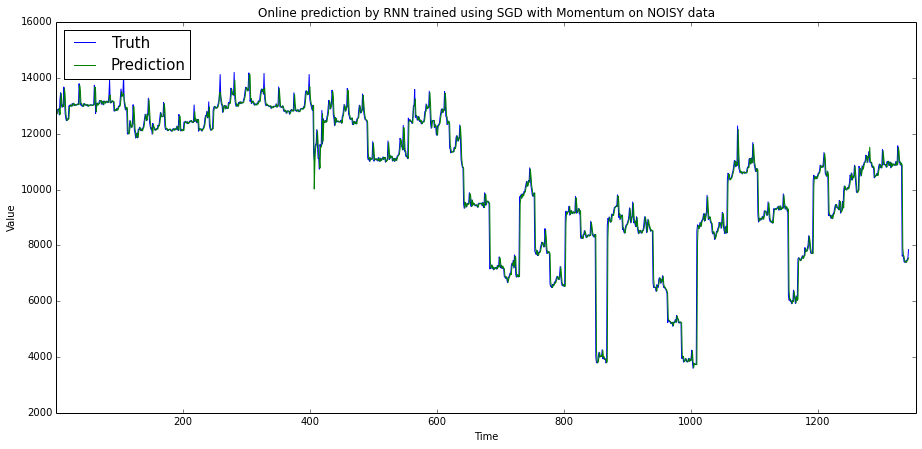

In [7]:
# block6: single run of the robust approach with the best learning rate
print outlier_tdf

dtax, dtay = format_timeseries_rnn( tdf['value'] )
sgd = SGD(lr= 0.005, momentum=0.03, decay=0.0, nesterov=True)
tst_x, tst_y, tst_pred_y, count = robustContinue_rl_train_rnn(dtax, dtay, sgd, \
                                    loss_func,ts_flag,0.0001, 80)
test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data",[])
print count


# 0.005, momentum=0.03


# 883         884   4513           1
# 884         885   5393           1
# 936         937   5412           1
# 1216       1217   3517           1
# 1217       1218   5088           1
# 1218       1219   4523           1
# 1219       1220   4827           1
# 1220       1221   4439           1
# 1221       1222   5737           1
# 1222       1223   5072           1

Normalzied MSE using SGD with Momentum on NOISY data:  11001.8095905


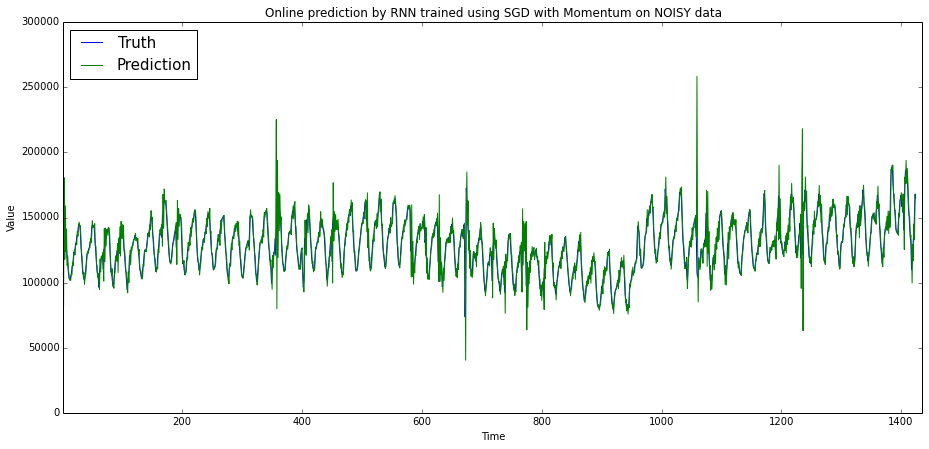

In [7]:
# block7: compare with conventional methods with the best learing rate

dtax, dtay = format_timeseries_rnn( tdf['value'] )
sgd = SGD(lr= 0.005, momentum=0.03, decay=0.0, nesterov=True)

tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data",[])


# dtax, dtay = format_timeseries_rnn(  clean_tdf['value'])
# allzero_ts_flag = [0]*len(dtax[0])
# sgd = SGD(lr= 0.005, momentum=0.03, decay=0.0, nesterov=True)

# tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
# test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "CLEAN data")

Normalzied MSE using SGD with Momentum on NOISY data:  11001.8095905


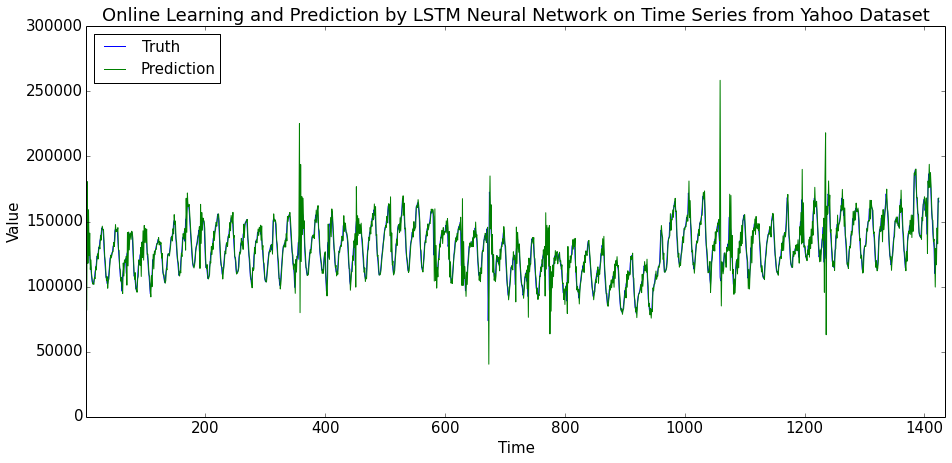

In [14]:
plt.subplot(3, 3, 1)



In [8]:
# block9: parameter selection for the robust approach
dtax, dtay = format_timeseries_rnn( tdf['value'] )
# 0.001, 0.005, 0.01,
lr_vals=[0.003,0.005,0.007 ]
win_len=[10, 30, 50, 70, 90, 110]
pred_y_lr_robust=[]

for tmp_lr in lr_vals:
    for tmp_win in win_len:
        
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        
        tst_x, tst_y, tst_pred_y, count = robustContinue_rl_train_rnn(dtax, dtay, sgd, \
                                    loss_func,ts_flag,0.0001, tmp_win)
        
        cnt= len(tst_y)
        nmse = sqrt(sum([(tst_y[i]- tst_pred_y[i])*(tst_y[i]- tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) + ',' + str(tmp_win)+ ' : ', nmse
# test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data",[])
        print count
        pred_y_lr_robust.append(tst_pred_y)
        
        
# Normalzied MSE 0.01,50 :  869.382018778
# 5
# Normalzied MSE 0.01,70 :  1000.28431272
# 5
# Normalzied MSE 0.01,90 :  977.602801967
# 6
# Normalzied MSE 0.01,110 :  895.309968655
# 7

Normalzied MSE 0.003,10 :  562.367041813
181
Normalzied MSE 0.003,30 :  475.443985699
100
Normalzied MSE 0.003,50 :  496.377895193
121
Normalzied MSE 0.003,70 :  440.143016118
97
Normalzied MSE 0.003,90 :  469.282184649
77
Normalzied MSE 0.003,110 :  458.38447284
70
Normalzied MSE 0.005,10 :  399.909571784
181
Normalzied MSE 0.005,30 :  402.999073819
100
Normalzied MSE 0.005,50 :  407.435199826
121
Normalzied MSE 0.005,70 :  408.013016935
97
Normalzied MSE 0.005,90 :  397.570401514
77
Normalzied MSE 0.005,110 :  392.479761623
70
Normalzied MSE 0.007,10 :  420.339365689
181
Normalzied MSE 0.007,30 :  421.671012162
100
Normalzied MSE 0.007,50 :  442.690687095
121
Normalzied MSE 0.007,70 :  421.487972921
97
Normalzied MSE 0.007,90 :  426.342716112
77
Normalzied MSE 0.007,110 :  420.918015939
70


In [ ]:
# block10: learning rate selection for the robust approach

prediction_para_plot( tst_y , pred_y_lr_robust , 'SGD' , "Learning rate " ,\
                     lr_vals, 'NOISY data' )


In [9]:
dtax, dtay = format_timeseries_rnn( tdf['value'] )
lr_vals=[0.0001,0.0005, 0.001, 0.005, 0.01 ]

# set of more fine learing rates 
lr_vals=[ 0.003, 0.005,0.007,0.009 ]


pred_y_lr_noise=[]
y_noise=[]

for tmp_lr in lr_vals:

    sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
    pred_y_lr_noise.append(tst_pred_y)
    y_noise.append( tst_y )
    
    cnt= len(tst_y)
    print len(tst_y), len(tst_pred_y)
    nmse = sqrt(sum([(tst_y[i]- tst_pred_y[i])*(tst_y[i]- tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
    print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse
    
    

# dtax, dtay = format_timeseries_rnn(  clean_tdf['value'])
# allzero_ts_flag = [0]*len(dtax[0])

# pred_y_lr_clean=[]
# y_clean=[]
# for tmp_lr in lr_vals:

#     sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
#     tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag,0.0001)
#     pred_y_lr_clean.append(tst_pred_y)
#     y_clean.append( tst_y )
    
#     cnt= len(tst_y)
#     print len(tst_y), len(tst_pred_y)
#     nmse = sqrt(sum([(tst_y[i]- tst_pred_y[i])*(tst_y[i]- tst_pred_y[i])\
#                          for i in range(cnt)])*1.0/cnt)
#     print 'Normalzied MSE '+ str(tmp_lr) + ' : ', nmse


# 1420 1420
# Normalzied MSE 0.0001 :  2272.61542653
# 1420 1420
# Normalzied MSE 0.0005 :  1565.49990705
# 1420 1420
# Normalzied MSE 0.001 :  1561.99506995
# 1420 1420
# Normalzied MSE 0.005 :  402.258558295
# 1420 1420
# Normalzied MSE 0.01 :  9372.91005445

1420 1420
Normalzied MSE 0.003 :  1268.96869918
1420 1420
Normalzied MSE 0.005 :  430.121519929
1420 1420
Normalzied MSE 0.007 :  4273.66281104
1420 1420
Normalzied MSE 0.009 :  8517.9385362


Numerical errors on SGD:
Normalzied MSE on Learning rate 0.001: 3930.56777035
Normalzied MSE on Learning rate 0.005: 3837.98552842
Normalzied MSE on Learning rate 0.01: 3660.67581562
Normalzied MSE on Learning rate 0.02: nan
Numerical errors on SGD:
Normalzied MSE on Learning rate 0.001: 2746.26981562
Normalzied MSE on Learning rate 0.005: 1191.25033852
Normalzied MSE on Learning rate 0.01: 1646.54092017
Normalzied MSE on Learning rate 0.02: nan


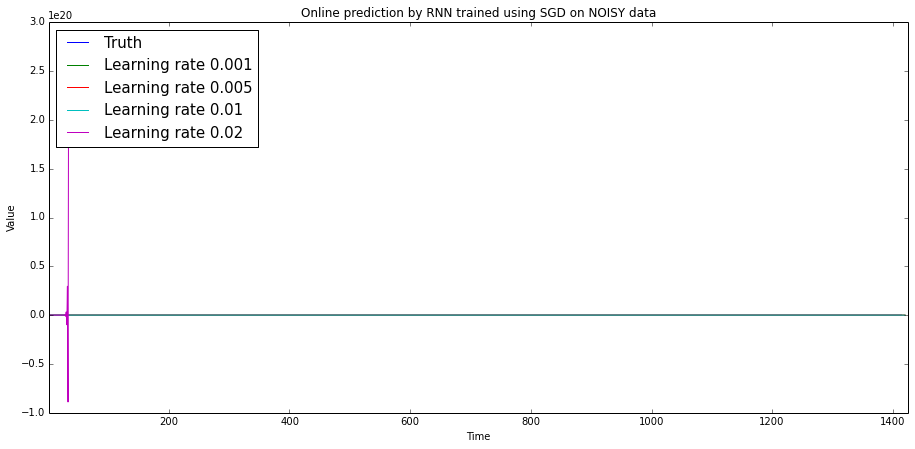

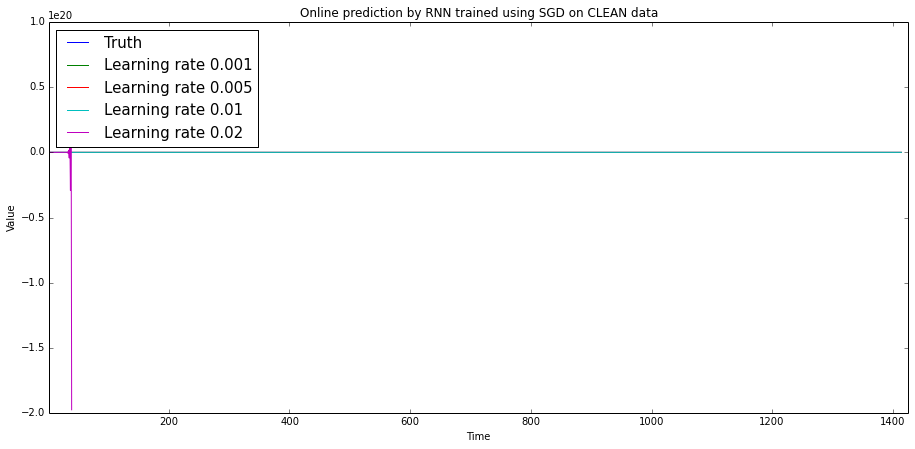

In [30]:
prediction_para_plot( tst_y , pred_y_lr_noise , 'SGD' , "Learning rate " , lr_vals, 'NOISY data' )
prediction_para_plot( tst_y , pred_y_lr_clean , 'SGD' , "Learning rate " , lr_vals,'CLEAN data' )

In [ ]:
# block5


conf_level=0.005

def sliding_window_statistic(cur_pos, rnn_model, winsize, dataX, dataY):
    
    tmpmean =0.0
    tmpsq =0.0
    tmpvar=0.0
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        
        tmpresi =  cur_trny - cur_pred
        
        tmpmean= tmpmean+tmpresi
        tmpsq= tmpsq + tmpresi*tmpresi
    
    tmpmean= tmpmean/winsize
    tmpvar= tmpsq/winsize - tmpmean**2
    
    return tmpmean, tmpvar
    
def sliding_window_features(cur_pos, rnn_model, winsize, dataX, dataY):
    
    tmpmean =0.0
    tmpsq =0.0
    tmpvar=0.0
    
    resi_list=[]
    vdrift_list=[]
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi =  cur_trny[0][0][0] - cur_pred
        
        vdrift_list.append(abs( dataX[:,i:i+1,:][0][0][0]-dataY[:,i:i+1,:][0][0][0] ) )
        resi_list.append( tmpresi )
        
        tmpmean= tmpmean+tmpresi
        tmpsq= tmpsq + tmpresi*tmpresi
    
    tmpmean= tmpmean/winsize
    tmpvar= tmpsq/winsize - tmpmean**2
    
    
#   extract features
    negcnt=0
    vd_sumsq=0.0
    vd_neg_sumsq=0.0
    
    for i in range(winsize):
        
        tmp_zval = (resi_list[i]-tmpmean )*1.0 / sqrt(tmpvar)
        tmp_pro =  st.norm.cdf( tmp_zval)
        if tmp_pro>(1-conf_level) or tmp_pro< conf_level:
            negcnt=negcnt+1
            
            vd_neg_sumsq = vd_neg_sumsq+ vdrift_list[i]**2
        
        vd_sumsq = vd_sumsq + vdrift_list[i]**2
        
        
    return negcnt*1.0/winsize, vd_neg_sumsq*1.0/vd_sumsq

def sliding_window_features_continuous(cur_pos,rnn_model, winsize, dataX, dataY,mean,var):
    
    tmpmean =0.0
    tmpsq =0.0
    tmpvar=0.0
    
    negcnt=0
    vd_sumsq=0.0
    vd_neg_sumsq=0.0
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi =  cur_trny[0][0][0] - cur_pred
        tmpvd = abs( dataX[:,i:i+1,:][0][0][0]-dataY[:,i:i+1,:][0][0][0] ) 
        
        tmp_zval = (tmpresi- mean )*1.0 / sqrt(var)
        tmp_pro =  st.norm.cdf( tmp_zval)
        if tmp_pro> 1-conf_level) or tmp_pro< conf_level:
            negcnt=negcnt+1
            vd_neg_sumsq = vd_neg_sumsq+ tmpvd**2
        
        vd_sumsq = vd_sumsq + tmpvd**2
        
    return negcnt*1.0/winsize, vd_neg_sumsq*1.0/vd_sumsq
        
    
def pvalue_rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, \
                        regular_para, \
                        pos_ratio, weight_ratio):
    
    timesteps =1 
    in_out_neurons = 1
    
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]

    rrl_model = Sequential()
    rrl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
    rrl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rrl_model.add(Activation("linear")) 

    rrl_model.compile(loss= loss_func, optimizer= optimizer_config )
    
    resi_mean= trnx[:,0:1,:][0][0][0]
    resi_sqr = trnx[:,0:1,:][0][0][0]**2
    resi_var= 0.0
    
    piece_mean= trnx[:,0:1,:][0][0][0]
    piece_sqr = trnx[:,0:1,:][0][0][0]**2
    piece_var= 0.0
    piece_cnt=1
    
    pre_mean= resi_mean
    pre_sqr = resi_sqr
    pre_var=  resi_var
    
    ma_mean= trnx[:,0:1,:][0][0][0]
    ma_sqr = trnx[:,0:1,:][0][0][0]**2
    ma_var= 1
    
    win_mean= trnx[:,0:1,:][0][0][0]
    win_sqr = trnx[:,0:1,:][0][0][0]**2
    win_var= 0.0
    
    seg_cnt=1
    
    win_size=70
    win_features=[]
    
    ma_lambda=0.6

    count=[[],[],[],[]]
    
    for i in range(1,trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
        
        tmp_cur_trnx = copy(trnx[:,i:i+1,:]) 
        tmp_cur_trny = copy(trny[:,i:i+1,:])
        
        cur_pred = rrl_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi = cur_trny[0][0][0] - cur_pred[0]
        
        
        if i>win_size+1:
            tmp_zval = (tmpresi-resi_mean )*1.0 / sqrt(resi_var)
            tmp_pro_conve =  st.norm.cdf( tmp_zval)
            if tmp_pro_conve>0.95 or tmp_pro_conve<0.05:
                count[0].append([i, tmp_pro_conve])
#                 print "at time step ",i,":\n", tmp_pro, resi_mean,resi_sqr, resi_var

                
            tmp_zval = (tmpresi-ma_mean )*1.0 / sqrt(ma_var)
            tmp_pro_ma =  st.norm.cdf( tmp_zval)
            if tmp_pro_ma>0.95 or tmp_pro_ma<0.05:
                count[1].append( [i, tmp_pro_ma] )
#                 print "   ", tmp_pro, resi_mean,resi_sqr, resi_var
                
            
            tmpmean, tmpvar=sliding_window_statistic(i, rrl_model, win_size, trnx, trny)
            tmp_zval = (tmpresi-tmpmean )*1.0 / sqrt(tmpvar)
            tmp_pro_win =  st.norm.cdf( tmp_zval)
            if tmp_pro_win>0.95 or tmp_pro_win<0.05:
                count[2].append( [i, tmp_pro_win] )
#                 print "   ", tmp_pro, resi_mean,resi_sqr, resi_var 

            tmp_zval = (tmpresi-  piece_mean )*1.0 / sqrt(piece_var)
            tmp_pro_piece =  st.norm.cdf( tmp_zval)
            if tmp_pro_piece > 0.95 or tmp_pro_piece<0.05:
                count[3].append( [i, tmp_pro_piece] )
#                 print "   ", tmp_pro, resi_mean,resi_sqr, resi_var
        
    
        rrl_model.train_on_batch(tmp_cur_trnx,tmp_cur_trny) 
        cur_pred = rrl_model.predict_on_batch( tmp_cur_trnx )[0][0][0]
        tmpresi = tmp_cur_trny[0][0][0] - cur_pred[0]

        
        resi_mean =  resi_mean* seg_cnt*1.0/(seg_cnt+1)+ tmpresi/(seg_cnt+1)
        resi_sqr = resi_sqr*seg_cnt*1.0/(seg_cnt+1)\
        + tmpresi*tmpresi/(seg_cnt+1)
        resi_var= resi_sqr - resi_mean* resi_mean
        
        
        ma_mean = (1.0-ma_lambda)* ma_mean* seg_cnt*1.0/(seg_cnt+1)\
             + ma_lambda*tmpresi/(seg_cnt+1)    
        ma_sqr = (1.0-ma_lambda)*ma_sqr*seg_cnt*1.0/(seg_cnt+1)\
        + ma_lambda*tmpresi*tmpresi/(seg_cnt+1)
        ma_var= ma_sqr - ma_mean* ma_mean
        
        seg_cnt = seg_cnt+1    
        
        
        pre_mean= piece_mean
        pre_sqr = piece_sqr
        pre_var=  piece_var
        
        piece_mean= ( piece_mean * piece_cnt*1.0 + tmpresi)/(piece_cnt+1)
        piece_sqr = piece_sqr + tmpresi*tmpresi
        piece_var= piece_sqr/(piece_cnt+1) - piece_mean* piece_mean
        piece_cnt = piece_cnt+1
        
        if abs(piece_mean-pre_mean) >= abs(pre_mean)*0.7:
                piece_mean= tmpresi
                piece_sqr = tmpresi*tmpresi
                piece_cnt = 1
                piece_var= piece_var*0.2
            
        
# ------------------------------------------------------------------------
# i%test_step ==0 and
        if i%test_step ==0 and ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rrl_model.predict_on_batch( vali_testx )[0][0][0]
#             print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0])
            testyh.append( pred_test   )
        
# ------------------------------------------------------------------------
    
#     print count
    
    return testx, testy, testyh, count

In [11]:
# block : train RNN under different regularization parameters

dtax, dtay = format_timeseries_rnn( tdf['value'] )
loss_func = "mean_squared_error"

res=[]

# Numerical errors on SGD:
# Normalzied MSE on learning rate 0.0001: 1456.61527475
# Normalzied MSE on learning rate 0.001: 1113.75949696
# Normalzied MSE on learning rate 0.01: 7149.09569761
# Numerical errors on RMSprop:
# Normalzied MSE on learning rate 0.0001: 6202.00966882
# Normalzied MSE on learning rate 0.001: 6180.13466764
# Normalzied MSE on learning rate 0.01: 5907.74801984
# Normalzied MSE on learning rate 0.1: 6142.40782181
# Normalzied MSE on learning rate 1: 2037.14537196
# Normalzied MSE on learning rate 10: 4638.25163999
# Numerical errors on Adam:
# Normalzied MSE on learning rate 0.0001: 6176.07928009
# Normalzied MSE on learning rate 0.001: 6173.49752375
# Normalzied MSE on learning rate 0.01: 6172.89995794
# Normalzied MSE on learning rate 0.1: 6167.62692063
# Normalzied MSE on learning rate 1: 6177.17675095
# Normalzied MSE on learning rate 10: 6169.10159163
# Numerical errors on Adamax:
# Normalzied MSE on learning rate 0.0001: 6181.2072312
# Normalzied MSE on learning rate 0.001: 6177.62932219
# Normalzied MSE on learning rate 0.01: 6182.41717582
# Normalzied MSE on learning rate 0.1: 6183.68513158
# Normalzied MSE on learning rate 1: 6178.6078663
# Normalzied MSE on learning rate 10: 6180.0857888

regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    sgd = SGD(lr= 0.001, momentum=0.05, decay=0.0, nesterov=True)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)


regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    rms = RMSprop(lr= 1, rho=0.9, epsilon=1e-06)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, rms, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)


regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    adagrad = Adagrad(lr=0.01, epsilon=1e-06)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adagrad, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)

regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adadelta, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)



regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    adam =  Adam(lr= 0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adam, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)


regu_vals=[0.0001,0.001, 0.01, 0.1, 1 ]
pred_y_lr=[]
for tmp in regu_vals:
    adamax = Adamax(lr= 1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    tst_x, tst_y, tst_pred_y = rl_train_rnn(dtax, dtay, adamax, loss_func,ts_flag, tmp)
    pred_y_lr.append(tst_pred_y)
res.append(pred_y_lr)
    


In [ ]:
def robustLocal_rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag,\
                             regular_para):
    
    timesteps =1 
    in_out_neurons = 1
    
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]

    rrl_model = Sequential()
    rrl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
    rrl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rrl_model.add(Activation("linear")) 

    rrl_model.compile(loss= loss_func, optimizer= optimizer_config )
    
    resi_mean= trnx[:,0:1,:][0][0][0]
    resi_sqr = trnx[:,0:1,:][0][0][0]**2
    resi_var= 0.0
    
    seg_cnt=1
    
    win_size=10
    weight_lambda = 0.2
    weight=1.0
    
    count=0
    
    for i in range(1,trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
        
        tmp_cur_trnx = copy(trnx[:,i:i+1,:]) 
        tmp_cur_trny = copy(trny[:,i:i+1,:])
        
        cur_pred = rrl_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi = cur_trny[0][0][0] - cur_pred[0]
        
        weight=1.0
        
        if i>win_size+1:
            
            
            neg_ratio,vd_ratio, curmean, curvar= sliding_window_features(i,rrl_model,\
                                                                      win_size, \
                                                        trnx,trny)
            
            
            tmp_zval = (tmpresi- curmean )*1.0 / sqrt(curvar)
            tmp_pro_conve =  st.norm.cdf( tmp_zval)
            
            if tmp_pro_conve>(1-conf_level) or tmp_pro_conve<conf_level:
                
                print "at time step:",i,":", neg_ratio, vd_ratio, \
                exp(-1*weight_lambda*neg_ratio  -1*(1.0-weight_lambda)*vd_ratio  ),\
                 exp(  -1*neg_ratio  )
                
                count=count+1
                
                weight=  exp(  -1*neg_ratio  )



        tmp_cur_trnx[0][0][0]= tmp_cur_trnx[0][0][0]*weight
        tmp_cur_trny[0][0][0]= tmp_cur_trny[0][0][0]*weight
    
        rrl_model.train_on_batch(tmp_cur_trnx,tmp_cur_trny) 
        
        
        cur_pred = rrl_model.predict_on_batch( tmp_cur_trnx )[0][0][0]
        tmpresi = tmp_cur_trny[0][0][0] - cur_pred[0]
        
        resi_mean =  resi_mean* seg_cnt*1.0/(seg_cnt+1)+ tmpresi/(seg_cnt+1)
        resi_sqr = resi_sqr*seg_cnt*1.0/(seg_cnt+1) + tmpresi*tmpresi/(seg_cnt+1)
        resi_var= resi_sqr - resi_mean* resi_mean
        
        seg_cnt = seg_cnt+1    
            
        
# ------------------------------------------------------------------------
# i%test_step ==0 and
        if ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rrl_model.predict_on_batch( vali_testx )[0][0][0]
#             print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0])
            testyh.append( pred_test   )
        
# ------------------------------------------------------------------------
    
#     print count
    
    return testx, testy, testyh, count



# block6: single run of the robust approach with the best learning rate
dtax, dtay = format_timeseries_rnn( tdf['value'] )
sgd = SGD(lr= 0.001, momentum=0.03, decay=0.0, nesterov=True)
tst_x, tst_y, tst_pred_y, count = robustLocal_rl_train_rnn(dtax, dtay, sgd, \
                                    loss_func,ts_flag,0.0001)
test_result_plot(tst_x, tst_y, tst_pred_y, opt_namelist[0], "NOISY data")
print count

# 883         884   4513           1
# 884         885   5393           1
# 936         937   5412           1
# 1216       1217   3517           1
# 1217       1218   5088           1
# 1218       1219   4523           1
# 1219       1220   4827           1
# 1220       1221   4439           1
# 1221       1222   5737           1
# 1222       1223   5072           1

In [ ]:
# synthetic data

seg_num=5
seg_len_min= 1000
seg_len_max= 4000

mean_min=1
mean_max= 100000
var_min = 1
var_max=100

num_multi_ts=1

figure_size= ( 13.4,7)

def generate_one_ts():
    
    tmpts=[]
    tcnt=0
    tmp_cp_list=[]
    for i in range(seg_num):
        seg_len = int(np.random.uniform([seg_len_min, seg_len_max, 1])[1])
        seg_mean = np.random.uniform([mean_min, mean_max, 1])[1]
        seg_var = seg_mean*0.01
#         np.random.uniform([var_min, var_max, 1])[1]
        
        if i ==0:
            seg_mean = np.random.uniform([1, 10, 1])[1]
            seg_var = seg_mean*0.01
        
        
        if i > 0:
            
        
        
        
        print "segment",i,":",seg_len, seg_mean, tcnt+seg_len
        tmp= np.random.normal( seg_mean, seg_var, seg_len )
        tmp_cp_list.append( tcnt )
        tcnt= tcnt + seg_len   
        [tmpts.append(i) for i in tmp]
    
    return tmpts, tmp_cp_list
    

# single time series wh1SoxZOaQ
sts, sts_cps= generate_one_ts()
print "lenght of time series:", len(sts)

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.plot(sts)
plt.title('Singel Time Series')
plt.ylabel('Values')
plt.xlabel('Time (seconds)')


# multi time series
tmp_mts=[]
tmp_mts_cps=[]
tmp_len=[]

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Multi-variate Time Series')
plt.ylabel('Values')
plt.xlabel('Time (seconds)')


for i in range(num_multi_ts):
    tmp_ts, tmp_cp_list= generate_one_ts()
    print "lenght of time series:", len(tmp_ts)
    tmp_len.append(len(tmp_ts))
    tmp_mts.append(tmp_ts)
    tmp_mts_cps.append(tmp_cp_list)
    
#  organize the format of multi-time series for feeding into RNN
mts_len = min(tmp_len)
tmp_mts = [ tmp_mts[i][:mts_len]    for i in range(num_multi_ts)  ]
[   plt.plot(tmp_mts[i]) for i in range(num_multi_ts)  ]


def extract_multiTS_tuple(idx):
    tmplist=[]
    for i in range(num_multi_ts):
        tmplist.append( tmp_mts[i][idx] )
    return tmplist

mul_ts= [ extract_multiTS_tuple(i) for i in range(mts_len) ]

# print len( mul_ts), len(mul_ts[0])


# ---------
if num_multi_ts >1:
    ts= mul_ts
else:
    ts= sts

print len(ts)

Normalzied MSE: 10.6533957326


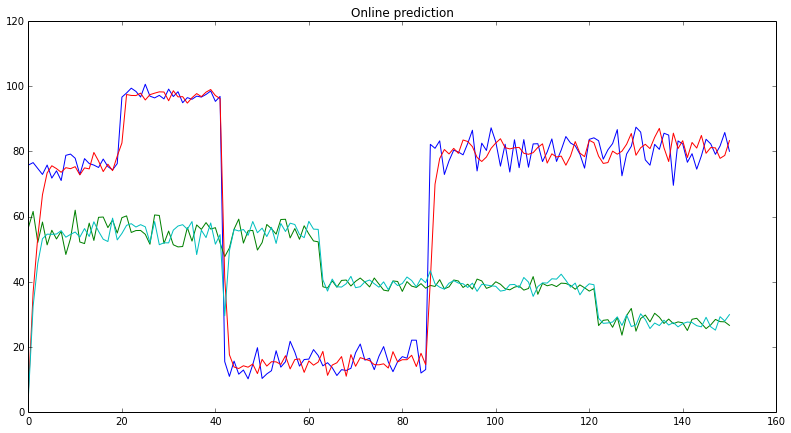

In [57]:
#  multi-variate synthetic time series

#  accuracy evaluation: plot
tst_mts_x = testx
tst_mts_y = testy
tst_mts_yh = testyh

fig = plt.figure()
fig.set_size_inches( figure_size )
plt.title('Online prediction')
plt.ylabel('Value')
plt.xlabel('Time (seconds)')

plt.plot(tst_mts_y)
plt.plot(tst_mts_yh)

#  error calculation
cnt= len(testy)

nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) for i in range(cnt)])*1.0/cnt)
print 'Normalzied MSE:', nmse


In [ ]:
#   Bayesian change point detection based on real-time learning of rnn

significance_level = 0.05

cur_seg_stPos=0
cur_seg_cnt=0
ini_run_len=100


#  residual statistics
resi_mean=0.0
resi_sqr = 0.0
resi_var=0.0

# parameter about the hazard function
hconst = 0.3
hrange= seg_len_max
hpiece_num=50
hpiece =[]
hpiece_event=[]
hpiece_psum=[]


# detected change-points
detect_cp_list=[]

# data instances for training RNN
xtrain= dtax
ytrain= dtay
total_len=len(xtrain) 
print xtrain.shape, ytrain.shape


# initialize the network structure
in_dim = 1
hidden_neurons = 800
timesteps =1
in_out_neurons = 2


cp_model = Sequential()
cp_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
               batch_input_shape = (1,timesteps,in_out_neurons )   ))
cp_model.add(Dropout(0.25))
cp_model.add(TimeDistributedDense(output_dim=in_out_neurons ) )
cp_model.add(Activation("linear"))
rms = RMSprop(lr=0.04, rho=0.9, epsilon=1e-06)
cp_model.compile(loss="mean_squared_error", optimizer=rms )


# initialize the model
cur_trnx= xtrain[:,0:1,:]
cur_trny= ytrain[:,0:1,:]
cp_model.train_on_batch(cur_trnx,cur_trny) 



# ---------------hazard function component------------
def hazard_bsearch( arr, t):
    
    tmplen=len(arr)
    l= 0
    r= tmplen
    
    while( l< r-1):
        mid= int(l+ (r-l)/2.0)
        tmpval= arr[mid][0]
        
        if tmpval> t:
            r= mid
        else:
            l=mid
    
    if t<= arr[l][0]:
        return l
    elif t>= arr[r][0]:
        return r+1
    else:
        return r
    
def hazard_constant():
    return hconst
    
def hazard_piece_ini():
    tmpinter = hrange*1.0 / hpiece_num
    tmph = 1.0 / hpiece_num
    curh=0.0
    
    for i in range(hpiece_num):
        curh= curh+ tmph
        hpiece.append(  [tmpinter*(i+1), curh ]  )
        
        hpiece_event.append(  [tmpinter*(i+1), 0 ]  )
        hpiece_psum.append(  0  )
            
def hazard_piece_qry( cond_t ):
    tmpidx = hazard_bsearch( hpiece, cond_t)
    return hpiece[tmpidx][1]
    
def hazard_update_event( t):
    tmpidx = hazard_bsearch( hpiece_event, t)
    hpiece_event[tmpidx][1] = hpiece_event[tmpidx][1]+1

def hazard_update_piece():
    
    tmp_psum=[]
    tmp=0.0
    tmpsum=0.0
    for i in range(hpiece_num):
        tmp = tmp+ hpiece_event[i][1]
        tmp_psum.append(tmp)
    
    tmpsum= tmp
    
    for i in range(hpiece_num):
        if (tmpsum- tmp_psum[i]+hpiece_event[i][1])!=0 and hpiece_event[i][1]!=0:
            hpiece[i][1] =  hpiece_event[i][1]*1.0/(tmpsum-tmp_psum[i]+hpiece_event[i][1])
    
def hazard_adjust_piece():
    return 1
    
    

#-------------------run-lenght  joint distribution ---------------------

rlen_dist=[]

def rlen_dist_ini():
    for i in range(seg_len_max):
        rlen_dist.append(0)
    rlen_dist[0]=1

def rlen_update( cur_rlen, pred_prob):
    
    rlen_dist[ cur_rlen ] = rlen_dist[ cur_rlen-1 ]*pred_prob* ( 1.0- hazard_piece_qry( cur_rlen-1 )) 
    
    rlen_dist[ 0 ] = rlen_dist[ cur_rlen-1 ]*pred_prob* ( hazard_piece_qry( cur_rlen-1 )) 

    
def rlen_evidence():
    tmpval=0.0
    for i in range(seg_len_max):
        tmpval =  tmpval + rlen_dist[i]
    return tmpval
    
def rlen_conditional(cur_rlen):
    
    return rlen_dist[cur_rlen]/rlen_evidence()

def rlen_renormal():
    return 1
   
# normalize the run-lenght distribution    
    
# --------------------------------------------------------------------
    
hazard_piece_ini()
# print hpiece

    
# the main process
for i in range(1,400):
    
    
#   current data instance for training the model
    cur_trnx= xtrain[:,i:i+1,:]
    cur_trny= ytrain[:,i:i+1,:]
    
#       use so-far training model to predict first 
    vali_testx=  xtrain[:, i:i+1,:]
    curPred= cp_model.predict_on_batch( vali_testx )
    
#       residual of the current data instance w.r.t. the predicted value
    tmpresi =  curPred[0][0][0][0] - ytrain[0, i, 0]
    
    
    if i - cur_seg_stPos <=  ini_run_len:
        
        resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
        cur_seg_cnt = cur_seg_cnt+1
        resi_sqr = resi_sqr + tmpresi*tmpresi
        resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean 
        
#         if i - cur_seg_stPos>= ini_run_len-10:
#             resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
#             cur_seg_cnt = cur_seg_cnt+1
#             resi_sqr = resi_sqr + tmpresi*tmpresi
#             resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean         
        
        
#       update the model for the current segment
        cp_model.train_on_batch(cur_trnx, cur_trny)
    
        print "initial phase:", tmpresi, resi_mean,resi_var
#         curPred[0][0][0][0],ytrain[0, i, 0]

        continue
        
#       z-value
    resi_mean=0.0
    tmp_zval = (tmpresi -  resi_mean)*1.0 / 1.0*sqrt(resi_var/cur_seg_cnt)
    tmp_pro =  st.norm.cdf( tmp_zval)
        
    print "at time step:",cur_seg_cnt,":", curPred[0][0][0][0], ytrain[0, i, 0], resi_mean,resi_var,tmp_pro
#     curPred, ytrain[:, i:i+1,:], tmp_zval   
    
    
#---------------test component------------------------


    resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/(cur_seg_cnt+1)
    cur_seg_cnt = cur_seg_cnt+1
    resi_sqr = resi_sqr + tmpresi*tmpresi
    resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean             
        
    cp_model.train_on_batch(cur_trnx, cur_trny) 
    
    
#------------------------------------------------------    
        
#     if tmp_pro <= significance_level or tmp_pro >= 1.0-significance_level:
# #       initialize a new segment 
#         cur_seg_stPos =i
#         cur_seg_cnt = 1
            
#         resi_mean= x[i]
#         resi_sqr = x[i]*x[i]*1.0
#         resi_var =  0.0
            
#         detect_cp_list.append(i)

#         reset weights
#         cp_model.reset_states()

#         cp_model.clear_previous(reset_weights=True)
        
# #       initialize a model for the new segment
#         cp_model.train_on_batch(cur_trnx,cur_trny) 
    
# #       update the hazard component
#         hazard_update_event(  i - cur_seg_stPos )
            
#     else:
        
# #      stay in the current segment and update the residual statistics 
#         resi_mean= ( resi_mean * cur_seg_cnt*1.0 + tmpresi)/cur_seg_cnt
#         cur_seg_cnt = cur_seg_cnt+1
#         resi_sqr = resi_sqr + tmpresi*tmpresi
#         resi_var= resi_sqr/cur_seg_cnt - resi_mean* resi_mean             
        
# #       update the model for the current segment
#         cp_model.train_on_batch(cur_trnx, cur_trny) 
    
            
            


In [ ]:
# block hazard comopnent test

# parameter about the hazard function
# hconst = 0.3
# hpiece_num=50

# hrange= seg_len_max
# hpiece =[]
# hpiece_event=[]
# hpiece_psum=[]


def hazard_bsearch( arr, t):
    
    tmplen=len(arr)
    l= 0
    r= tmplen
    
    while( l< r-1):
        mid= int(l+ (r-l)/2.0)
        tmpval= arr[mid][0]
        
        if tmpval> t:
            r= mid
        else:
            l=mid
    
    if t<= arr[l][0]:
        return l
    elif t>= arr[r][0]:
        return r+1
    else:
        return r
    
def hazard_constant():
    return hconst
    
def hazard_piece_ini():
    tmpinter = hrange*1.0 / hpiece_num
    tmph = 1.0 / hpiece_num
    curh=0.0
    
    for i in range(hpiece_num):
        curh= curh+ tmph
        hpiece.append(  [tmpinter*(i+1), curh ]  )
        
        hpiece_event.append(  [tmpinter*(i+1), 0 ]  )
        hpiece_psum.append(  0  )
            
def hazard_piece_qry( cond_t ):
    tmpidx = hazard_bsearch( hpiece, cond_t)
    return hpiece[tmpidx][1]
    
def hazard_update_event( t):
    tmpidx = hazard_bsearch( hpiece_event, t)
    hpiece_event[tmpidx][1] = hpiece_event[tmpidx][1]+1

def hazard_update_piece():

#   mechanism for keepting default values
    tmp_psum=[]
    tmp=0.0
    tmpsum=0.0
    for i in range(hpiece_num):
        tmp = tmp+ hpiece_event[i][1]
        tmp_psum.append(tmp)
    
    tmpsum= tmp
    
    for i in range(hpiece_num):
        hpiece[i][1] =  hpiece_event[i][1]*1.0/(tmpsum- tmp_psum[i]+hpiece_event[i][1])
    
    

    
# ...................test.........................

# print hazard_constant()
# hazard_piece_ini()
# print hpiece
# hazard_piece_qry(201)

# hazard_update_event(4130)    
print hpiece_event
    
hazard_update_piece()

print hpiece

In [ ]:
#  build online-rnn learning framework


#  state-full lstm 
#  https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py

# Q&A:
#  stateful lstm
#  variational
#  time steps: maximum time lag?
#  if residula is not white gaussian 

#  septerate modeling on conditions


In [ ]:
# block5

def robust_rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, regular_para, \
                        pos_ratio, weight_ratio):
    
    timesteps =1 
    in_out_neurons = 1
    
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]

    rrl_model = Sequential()
    rrl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
    rrl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rrl_model.add(Activation("linear")) 

    rrl_model.compile(loss= loss_func, optimizer= optimizer_config )
    
    resi_mean= trnx[:,0:1,:][0][0][0]
    resi_sqr = trnx[:,0:1,:][0][0][0]**2
    resi_var= 0.0
    
    pre_resi_mean= trnx[:,0:1,:][0][0][0]
    pre_resi_sqr = trnx[:,0:1,:][0][0][0]**2
    pre_resi_var= 0.0 
    
    seg_cnt=1

    ma_vshift=0.0
    ma_coef=0.7
    vshift_bound = 2
    
    mker_vshift = 0.0
    
    pre_pro=0.0
    
    win_size=10
    win_features=[]
    
    weight_lambda=0.5
    mean_lambda=0.6
    var_lambda=0.6
    
    for i in range(1,trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
        
        tmp_cur_trnx = copy(trnx[:,i:i+1,:]) 
        tmp_cur_trny = copy(trny[:,i:i+1,:])
        
        cur_pred = rrl_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi = cur_trny[0][0][0] - cur_pred[0]
        
        
        if i>2:
            tmp_zval = (tmpresi-resi_mean )*1.0 / sqrt(resi_var)
            tmp_pro =  st.norm.cdf( tmp_zval)
            
            if tmp_pro>0.95 or tmp_pro<0.05:
                print "at time step:",i,":", tmp_pro, resi_mean,resi_sqr, resi_var
        
#         if i>win_size:
# #             and seg_cnt >= 1:
            
#             tmp_zval = (tmpresi-resi_mean )*1.0 / sqrt(resi_var)
#             tmp_pro =  st.norm.cdf( tmp_zval)
            
#             if tmp_pro>0.95 or tmp_pro<0.05:
                
# #               derive weight baed on the window features
#                 win_mean=0.0
#                 win_var=0.0
#                 win_sq=0.0
#                 pos_cnt = 0.0
#                 for tup in win_features:
#                     pos_cnt= pos_cnt+tup[0]
                    
#                     win_mean = win_mean + tup[1]*(1-tup[0])
#                     win_sq = win_sq + tup[1]*tup[1]*(1-tup[0])
                     
#                 if (win_size-pos_cnt)>0:
#                     win_var= win_sq*1.0/(win_size-pos_cnt) - \
#                     ( win_mean*1.0/(win_size-pos_cnt) )**2
                
#                 pos_percen = pos_cnt*1.0 / win_size
                
#                 if pos_cnt*1.0 / win_size > pos_ratio:
#                     weight = weight_ratio
                                    
#                 elif win_var > 100:
#                     weight = weight_ratio
#                 else:
#                     weight=1

                
#                 gweight = exp( -1* (weight_lambda*pos_percen + (1.0-weight_lambda)*\
#                                     sqrt(win_var))  )
                
#                 print "at time step:",i,":",tmp_pro,pos_cnt,win_mean,win_var,\
#                 outlier_flag[i], weight, gweight
                
                    
# #               weight the training sample
# #                 tmp_cur_trnx[0][0][0] = cur_trnx[0][0][0] * weight
# #                 tmp_cur_trny[0][0][0] =  cur_trny[0][0][0] * weight

# #               update the local window
#                 win_features.pop(0)
#                 win_features.append( [ 0, trnx[:,i:i+1,:][0][0][0]-trnx[:,i-1:i,:][0][0][0] ] )
        
     
#             else:
                
# #               update the local window
#                 win_features.pop(1)
#                 win_features.append( [ 1, trnx[:,i:i+1,:][0][0][0]-trnx[:,i-1:i,:][0][0][0] ] )
        
#         else:
            
#             tmp_zval = (tmpresi-resi_mean )*1.0 / sqrt(resi_var)
#             tmp_pro =  st.norm.cdf( tmp_zval)
            
#             if tmp_pro>0.95 or tmp_pro<0.05:
#                 win_features.append( [ 0, trnx[:,i:i+1,:][0][0][0]-trnx[:,i-1:i,:][0][0][0] ] )
#             else:
#                 win_features.append( [ 1, trnx[:,i:i+1,:][0][0][0]-trnx[:,i-1:i,:][0][0][0] ] )

#         print "at time step:",i,":", tmp_pro, outlier_flag[i]
        
        
    
    
    
        rrl_model.train_on_batch(tmp_cur_trnx,tmp_cur_trny) 
        
        pre_resi_mean= resi_mean
        pre_resi_sqr = resi_sqr
        pre_resi_var=  resi_var
        
        cur_pred = rrl_model.predict_on_batch( tmp_cur_trnx )[0][0][0]
        tmpresi = tmp_cur_trny[0][0][0] - cur_pred[0]
        
#         resi_mean=  resi_mean * seg_cnt*1.0/(seg_cnt+1)     + tmpresi/(seg_cnt+1)
        resi_mean =  resi_mean* seg_cnt*1.0/(seg_cnt+1)+ tmpresi/(seg_cnt+1)
    
        resi_sqr = resi_sqr*seg_cnt*1.0/(seg_cnt+1)\
        + tmpresi*tmpresi/(seg_cnt+1)

        
#         resi_sqr = (1.0-mean_lambda)*resi_sqr + mean_lambda*tmpresi*tmpresi
        
        resi_var= resi_sqr - resi_mean* resi_mean
        
#         print resi_mean,resi_sqr, resi_var
        
        seg_cnt = seg_cnt+1
        
#         if abs(resi_mean-pre_resi_mean) >= abs(pre_resi_mean)*0.4:
#             resi_mean= tmpresi
#             resi_sqr = tmpresi*tmpresi
#             seg_cnt = 1
#             resi_var= resi_var*0.8
        
    
#         if not (tmp_pro>0.995 or tmp_pro<0.005):
          
#             pre_resi_mean= resi_mean
#             pre_resi_sqr = resi_sqr
#             pre_resi_var=  resi_var
        
#             cur_pred = rrl_model.predict_on_batch( cur_trnx )[0][0][0]
#             tmpresi = cur_trny[0][0][0] - cur_pred[0]
        
#             resi_mean= ( resi_mean * seg_cnt*1.0 + tmpresi)/(seg_cnt+1)
#             resi_sqr = resi_sqr + tmpresi*tmpresi
#             resi_var= resi_sqr/(seg_cnt+1) - resi_mean* resi_mean
#             seg_cnt = seg_cnt+1
        
#             if abs(resi_mean-pre_resi_mean) >= abs(pre_resi_mean)*0.1:
#                 resi_mean= tmpresi
#                 resi_sqr = tmpresi*tmpresi
#                 seg_cnt = 1
#                 resi_var= resi_var*0.8

            
#             resi_sqr/(seg_cnt) - resi_mean* resi_mean
#         ma_vshift = (1.0-ma_coef)*ma_vshift + ma_coef*\
#         (trny[:,i:i+1,:][0][0][0]-trnx[:,i:i+1,:][0][0][0])
        
        
# ------------------------------------------------------------------------
# i%test_step ==0 and
        if i%test_step ==0 and ts_flag[i+2]!=1 and ts_flag[i+1]!=1 :
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rrl_model.predict_on_batch( vali_testx )[0][0][0]
#             print "at time step:",i,":", pred_test, "--v.s.--",trnx[:, i+2:i+3,:][0][0]
        
            testx.append( vali_testx[0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0])
            testyh.append( pred_test   )
        
# ------------------------------------------------------------------------
        
        
    return testx, testy, testyh